In [163]:
import pandas
import numpy
import pygsheets
import scipy.stats
import datetime
import matplotlib
import matplotlib.pyplot as mp

## colors for plots

In [164]:
sel_cmap = matplotlib.cm.get_cmap('Oranges')
tracker_construction = sel_cmap(1.0)
tracker_proposed = sel_cmap(0.75)

## import terminals data from sheet

In [165]:
credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
spreadsheet = gc.open_by_key('1uyMeL9f2zF3YlpTUlvptrP9YW-reCrO_tLibyOi_emk') # copy for this report

#spreadsheet[1] "Gas Pipelines" tab is the second index
terms_df_orig = spreadsheet.worksheet('title', 'Terminals').get_as_df(start='A2')

In [166]:
# replace all -- with nans
terms_df_orig.replace('--', numpy.nan, inplace=True)
# remove oil export terminals
terms_df_orig = terms_df_orig.loc[terms_df_orig['Fuel']!='Oil']
# remove anything without a wiki page
terms_df_orig = terms_df_orig.loc[terms_df_orig['Wiki']!='']
# remove N/A statuses
terms_df_orig = terms_df_orig.loc[terms_df_orig['Status']!='']

In [167]:
region_df_orig = spreadsheet.worksheet('title', 'Region dictionary').get_as_df(start='A2')
region_df_africa = region_df_orig.loc[(region_df_orig['AfricaGasTracker']=='Yes')]
region_df_touse = region_df_africa.copy()

In [168]:
status_list = ['Proposed', 'Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']
country_list = sorted(list(set(terms_df_orig['Country'])))
region_list = sorted(list(set(terms_df_orig['Region'])))

## table for exports

In [169]:
#mtpa by country
mtpa_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
mtpa_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                   (terms_df_orig['Import/Export']=='Export')&
                                                   (terms_df_orig.Status==status)]
    mtpa_by_country_df[status] = temp_df.groupby('Country')['CapacityInMtpa'].sum()

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                  (terms_df_orig['Import/Export']=='Export')&
                                                  (terms_df_orig.Status==status)]
    mtpa_by_region_df[status] = temp_df.groupby('Region')['CapacityInMtpa'].sum()

mtpa_by_country_df = mtpa_by_country_df.fillna(0)
mtpa_by_region_df = mtpa_by_region_df.fillna(0)

# add total and proposed+construction info
mtpa_by_region_df['Proposed+Construction'] = mtpa_by_region_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_region_df = mtpa_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

mtpa_by_country_df['Proposed+Construction'] = mtpa_by_country_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_country_df = mtpa_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# total
if 'Total' in mtpa_by_region_df.index:
    mtpa_by_region_df.drop(index='Total', inplace=True)   
    total = mtpa_by_region_df.sum(axis=0)
    total.name='Total'
    mtpa_by_region_df = mtpa_by_region_df.append(total)

else:
    total = mtpa_by_region_df.sum(axis=0)
    total.name='Total'
    mtpa_by_region_df = mtpa_by_region_df.append(total)

# total
if 'Total' in mtpa_by_country_df.index:
    mtpa_by_country_df.drop(index='Total', inplace=True)   
    total = mtpa_by_country_df.sum(axis=0)
    total.name='Total'
    mtpa_by_country_df = mtpa_by_country_df.append(total)

else:
    total = mtpa_by_country_df.sum(axis=0)
    total.name='Total'
    mtpa_by_country_df = mtpa_by_country_df.append(total)

# save countries
mtpa_by_country_df = mtpa_by_country_df.loc[~(mtpa_by_country_df==0).all(axis=1)]
mtpa_by_country_df.to_excel('mtpa-by-country-export.xlsx')

mtpa_by_region_export_df = mtpa_by_region_df.copy()
mtpa_by_country_export_df = mtpa_by_country_df.copy()

mtpa_by_region_df

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_62669/1996867698.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mtpa_by_region_df = mtpa_by_region_df.append(total)
/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_62669/1996867698.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mtpa_by_country_df = mtpa_by_country_df.append(total)


,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
North America,421.15000,39.36000,460.51000,12.29000,444.11000,73.90000,15.30000,1.50000,0.00000
Eurasia,115.40000,19.60000,135.00000,14.42000,16.36000,30.60000,0.00000,0.00000,0.00000
Sub-Saharan Africa,77.42000,10.52000,87.94000,34.10000,27.39000,37.72000,0.00000,0.00000,0.00000
Middle East and North Africa,63.60000,1.07000,64.67000,22.00000,87.75000,136.94000,0.00000,10.40000,7.80000
SE Asia,19.50000,5.80000,25.30000,1.50000,12.55000,66.65000,0.00000,0.00000,30.10000
Australia and New Zealand,20.10000,0.00000,20.10000,7.20000,45.80000,87.60000,0.00000,0.00000,0.00000
Latin America and the Caribbean,5.37000,0.00000,5.37000,0.00000,16.60000,16.45000,0.00000,3.75000,0.00000
East Asia,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Europe,0.00000,0.00000,0.00000,0.00000,5.04000,4.68000,0.00000,0.00000,0.00000
South Asia,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


## table for imports

In [170]:
#mtpa by country
mtpa_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
mtpa_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                   (terms_df_orig['Import/Export']=='Import')&
                                                   (terms_df_orig.Status==status)]
    mtpa_by_country_df[status] = temp_df.groupby('Country')['CapacityInMtpa'].sum()

for status in status_list:
    #print(status)
    temp_df = terms_df_orig.loc[(terms_df_orig.Fuel=='LNG')&
                                                  (terms_df_orig['Import/Export']=='Import')&
                                                  (terms_df_orig.Status==status)]
    mtpa_by_region_df[status] = temp_df.groupby('Region')['CapacityInMtpa'].sum()

mtpa_by_country_df = mtpa_by_country_df.fillna(0)
mtpa_by_region_df = mtpa_by_region_df.fillna(0)

# add total and proposed+construction info
mtpa_by_region_df['Proposed+Construction'] = mtpa_by_region_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_region_df = mtpa_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

mtpa_by_country_df['Proposed+Construction'] = mtpa_by_country_df[['Proposed','Construction']].sum(axis=1)
mtpa_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
mtpa_by_country_df = mtpa_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
mtpa_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# total
if 'Total' in mtpa_by_region_df.index:
    mtpa_by_region_df.drop(index='Total', inplace=True)   
    total = mtpa_by_region_df.sum(axis=0)
    total.name='Total'
    mtpa_by_region_df = mtpa_by_region_df.append(total)

else:
    total = mtpa_by_region_df.sum(axis=0)
    total.name='Total'
    mtpa_by_region_df = mtpa_by_region_df.append(total)

# total
if 'Total' in mtpa_by_country_df.index:
    mtpa_by_country_df.drop(index='Total', inplace=True)   
    total = mtpa_by_country_df.sum(axis=0)
    total.name='Total'
    mtpa_by_country_df = mtpa_by_country_df.append(total)

else:
    total = mtpa_by_country_df.sum(axis=0)
    total.name='Total'
    mtpa_by_country_df = mtpa_by_country_df.append(total)

# save countries
# drop all all-zero columns
mtpa_by_country_df = mtpa_by_country_df.loc[~(mtpa_by_country_df==0).all(axis=1)]
mtpa_by_country_df.to_excel('mtpa-by-country-import.xlsx')

mtpa_by_region_import_df = mtpa_by_region_df.copy()
mtpa_by_country_import_df = mtpa_by_country_df.copy()

mtpa_by_region_df

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_62669/1390453538.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mtpa_by_region_df = mtpa_by_region_df.append(total)
/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_62669/1390453538.py:55: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mtpa_by_country_df = mtpa_by_country_df.append(total)


,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
East Asia,149.76000,91.25000,241.01000,25.80000,54.49000,444.10000,0.00000,1.50000,0.00000
Europe,136.72000,28.61000,165.33000,14.20000,91.24000,181.03000,0.00000,0.00000,3.00000
South Asia,69.71000,33.00000,102.71000,8.38000,80.95000,65.20000,0.00000,0.00000,0.00000
SE Asia,76.84000,21.66000,98.50000,8.40000,28.34000,45.05000,0.00000,0.00000,0.00000
Latin America and the Caribbean,43.48000,12.28000,55.76000,6.46000,16.07000,53.36000,0.00000,0.00000,0.00000
Sub-Saharan Africa,6.88000,1.70000,8.58000,0.50000,7.70000,0.11000,0.00000,0.00000,0.00000
Australia and New Zealand,3.30000,1.90000,5.20000,0.00000,1.75000,0.00000,0.00000,0.00000,0.00000
Middle East and North Africa,5.15000,0.00000,5.15000,11.10000,18.64000,48.90000,11.80000,0.00000,0.00000
North America,0.05000,0.00000,0.05000,0.00000,268.42000,81.10000,25.00000,45.00000,17.30000
Eurasia,0.00000,0.00000,0.00000,0.00000,0.00000,12.20000,0.00000,0.00000,0.00000


# table 1

In [171]:
status = ['Operating']
mtpa_by_country_import_df_subset = mtpa_by_country_import_df.loc[(mtpa_by_country_import_df.index.isin(region_df_touse.Country))]
mtpa_by_country_import_df_subset = mtpa_by_country_import_df_subset.sort_values(status, ascending=False)[status]
# sum everything after top 5
upto = 2
rest_of_africa = pandas.DataFrame(mtpa_by_country_import_df_subset[5:].sum()).transpose()
rest_of_africa.rename(index={0:'Rest of Africa'}, inplace=True)
final_table = pandas.concat([mtpa_by_country_import_df_subset[:upto],rest_of_africa])
final_table.loc['Total'] = final_table.sum().values
final_table.index.name = 'Country'
final_table

,Operating
Country,
Egypt,5.70000
Senegal,0.11000
Rest of Africa,0.00000
Total,5.81000


## fig for table 2

# table 2

In [173]:
status = ['Operating']
mtpa_by_country_export_df_subset = mtpa_by_country_export_df.loc[(mtpa_by_country_export_df.index.isin(region_df_touse.Country))]
mtpa_by_country_export_df_subset = mtpa_by_country_export_df_subset.sort_values(status, ascending=False)[status]
# sum everything after top 5
upto = 5
rest_of_africa = pandas.DataFrame(mtpa_by_country_export_df_subset[5:].sum()).transpose()
rest_of_africa.rename(index={0:'Rest of Africa'}, inplace=True)
final_table = pandas.concat([mtpa_by_country_export_df_subset[:upto],rest_of_africa])
final_table.loc['Total'] = final_table.sum().values
final_table.index.name = 'Country'
final_table

,Operating
Country,
Algeria,29.34000
Nigeria,23.02000
Egypt,12.20000
Angola,5.20000
Equatorial Guinea,3.70000
Rest of Africa,5.80000
Total,79.26000


## fig for table 2 (now Fig 1)

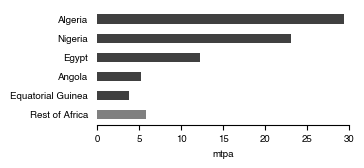

In [174]:
font_size = 7
set_width = 0.5
use_this_df = final_table.sort_values('Operating').drop('Total')
rest_df = use_this_df.loc[['Rest of Africa']]
use_this_df = pandas.concat([rest_df, use_this_df.drop('Rest of Africa')])
ytop = final_table.index.size

fig = mp.figure(figsize=(3.25,1.5))
ax = fig.add_subplot(111)

ax.barh(range(use_this_df.index.size), use_this_df['Operating'],
       color=['0.5']+['0.25']*5, label=['Operating']*use_this_df.index.size, height=set_width)

# ax_h,ax_l = ax.get_legend_handles_labels()
# ax.legend([ax_h[-1]], [ax_l[-1]], fontsize=font_size, frameon=False, handlelength=0.75, loc=4)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(labelsize=font_size,
              left=False)
ax.set_xlabel('mtpa', size=font_size)

ax.yaxis.set_ticks(range(use_this_df.index.size))
ax.yaxis.set_ticklabels(use_this_df.index, size=font_size, va='center')
#ax.set_ylim(ybot,ytop)
ax.set_xlim(0, 30)
#ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

# ax.set_title('Regional Export Capacity', fontsize=font_size)

mp.savefig('saved-figures/africa-export-capacity-operating-fig1.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/africa-export-capacity-operating-fig1.pdf',
          bbox_inches='tight', 
          transparent=True)

mp.savefig('saved-figures/africa-export-capacity-operating-fig1.svg',
          bbox_inches='tight', 
          transparent=True)

# table 4

In [175]:
status = ['Proposed','Construction','Proposed+Construction']
mtpa_by_country_export_df_subset = mtpa_by_country_export_df.loc[(mtpa_by_country_export_df.index.isin(region_df_touse.Country))]
mtpa_by_country_export_df_subset = mtpa_by_country_export_df_subset.sort_values('Proposed+Construction', ascending=False)[status]
# sum everything after top 5
upto = 5
rest_of_africa = pandas.DataFrame(mtpa_by_country_export_df_subset[5:].sum()).transpose()
rest_of_africa.rename(index={0:'Rest of Africa'}, inplace=True)
final_table = pandas.concat([mtpa_by_country_export_df_subset[:upto],rest_of_africa])
final_table.loc['Total'] = final_table.sum().values
final_table.index.name = 'Country'
final_table

,Proposed,Construction,Proposed+Construction
Country,,,
Nigeria,16.02000,8.00000,24.02000
Mauritania,17.50000,2.52000,20.02000
Mozambique,15.20000,0.00000,15.20000
Tanzania,10.00000,0.00000,10.00000
Senegal,10.00000,0.00000,10.00000
Rest of Africa,8.70000,0.07000,8.77000
Total,77.42000,10.59000,88.01000


## figure for table 4 (now Fig 3)

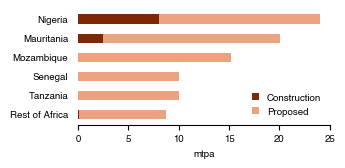

In [177]:
font_size = 7
set_width = 0.5
use_this_df = final_table.sort_values('Proposed+Construction').drop('Total')
ytop = final_table.index.size

fig = mp.figure(figsize=(3.25,1.5))
ax = fig.add_subplot(111)

ax.barh(range(use_this_df.index.size), use_this_df['Construction'],
       color=tracker_construction, label='Construction', height=set_width)
ax.barh(range(use_this_df.index.size), use_this_df['Proposed'],
       color=tracker_proposed, label='Proposed',
      left=use_this_df['Construction'], height=set_width, alpha=0.5)

ax_l,ax_h = ax.get_legend_handles_labels()
ax.legend(ax_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=4)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(labelsize=font_size,
              left=False)
ax.set_xlabel('mtpa', size=font_size)

ax.yaxis.set_ticks(range(use_this_df.index.size))
ax.yaxis.set_ticklabels(use_this_df.index, size=font_size, va='center')
#ax.set_ylim(ybot,ytop)
ax.set_xlim(0, 25)
#ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

# ax.set_title('Regional Export Capacity', fontsize=font_size)

mp.savefig('saved-figures/africa-export-capacity-in-dev-fig3.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/africa-export-capacity-in-dev-fig3.pdf',
          bbox_inches='tight', 
          transparent=True)

mp.savefig('saved-figures/africa-export-capacity-in-dev-fig3.svg',
          bbox_inches='tight', 
          transparent=True)

# import terminals table

In [178]:
status = ['Proposed','Construction','Proposed+Construction']
mtpa_by_country_import_df_subset = mtpa_by_country_import_df.loc[(mtpa_by_country_import_df.index.isin(region_df_touse.Country))]
mtpa_by_country_import_df_subset = mtpa_by_country_import_df_subset.sort_values('Proposed+Construction', ascending=False)[status]
# sum everything after top 5
upto = 5
rest_of_africa = pandas.DataFrame(mtpa_by_country_import_df_subset[5:].sum()).transpose()
rest_of_africa.rename(index={0:'Rest of Africa'}, inplace=True)
final_table = pandas.concat([mtpa_by_country_import_df_subset[:upto],rest_of_africa])
final_table.loc['Total'] = final_table.sum().values
final_table.index.name = 'Country'
final_table

,Proposed,Construction,Proposed+Construction
Country,,,
South Africa,6.00000,0.00000,6.00000
Morocco,5.15000,0.00000,5.15000
Ghana,0.00000,1.70000,1.70000
Mozambique,0.50000,0.00000,0.50000
Côte d'Ivoire,0.38000,0.00000,0.38000
Rest of Africa,0.00000,0.00000,0.00000
Total,12.03000,1.70000,13.73000


# cost calculations

## create offshore and floating dfs

In [179]:
# insane outliers
# Ravenna - T068300
# Gorgon LNG (megaproject) - T068300
# Tanzania LNG Terminal trains 1, 2 - T026301, T026302
# Coral South FLNG Terminal - includes deep gas well construction - T025801
outlier_comboids = ['T068300','T068300','T026301','T026302','T025801']

In [180]:
terms_df_floating = terms_df_orig.loc[terms_df_orig.Floating=='yes']
terms_df_onshore = terms_df_orig.loc[terms_df_orig.Floating=='']

#terms_df_floating = terms_df_floating.loc[~terms_df_floating.ComboID.isin(outlier_comboids)]
#terms_df_onshore = terms_df_onshore.loc[~terms_df_onshore.ComboID.isin(outlier_comboids)]
terms_df_floating = terms_df_floating.loc[terms_df_floating.CostUSDPerMtpa<1e9]
terms_df_onshore = terms_df_onshore.loc[terms_df_onshore.CostUSDPerMtpa<1e9]

In [181]:
terms_df_floating_noexpansions = terms_df_floating.loc[~terms_df_floating['UnitName'].str.contains('Expansion')].drop_duplicates(subset=['TerminalName'], keep='first')
terms_df_onshore_noexpansions = terms_df_onshore.loc[~terms_df_onshore['UnitName'].str.contains('Expansion')].drop_duplicates(subset=['TerminalName'], keep='first')

## import

In [182]:
terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide_index()

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_62669/935618189.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&


TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Tema FSRU,Ghana,Construction,https://www.gem.wiki/Tema_FSRU,205882352.900000
Coega FSRU,South Africa,Proposed,https://www.gem.wiki/Coega_FSRU,500000000.000000
Kutubdia (Reliance) FSRU,Bangladesh,Cancelled,https://www.gem.wiki/Kutubdia_(Reliance)_FSRU,84444444.270000
Moheshkhali FLNG Terminal (Petrobangla),Bangladesh,Operating,https://www.gem.wiki/Moheshkhali_FLNG_Terminal_(Petrobangla),47236842.110000
Jawa Satu FSRU,Indonesia,Operating,https://www.gem.wiki/Jawa_Satu_FSRU,145833333.300000
Newcastle FSRU,Australia,Proposed,https://www.gem.wiki/Newcastle_FSRU,406410000.000000
Eagle FLNG Terminal,Albania,Cancelled,https://www.gem.wiki/Eagle_FLNG_Terminal,140740740.700000
Krk FSRU,Croatia,Operating,https://www.gem.wiki/Krk_FSRU,124887381.400000
Cyprus LNG Terminal,Cyprus,Construction,https://www.gem.wiki/Cyprus_LNG_Terminal,592800000.000000
Wilhelmshaven FSRU,Germany,Construction,https://www.gem.wiki/Wilhelmshaven_FSRU,93023991.320000


In [183]:
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide_index()

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_62669/1041829456.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&


TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Jorf Lasfar LNG Terminal,Morocco,Proposed,https://www.gem.wiki/Jorf_Lasfar_LNG_Terminal,874285632.700000
Kutubdia LNG Terminal (Petronet),Bangladesh,Cancelled,https://www.gem.wiki/Kutubdia_LNG_Terrminal_(Petronet),84444444.400000
Lahad Datu Sabah LNG Terminal,Malaysia,Cancelled,https://www.gem.wiki/Lahad_Datu_Sabah_LNG_Terminal,317105263.200000
Pengerang Johor LNG Terminal,Malaysia,Operating,https://www.gem.wiki/Pengerang_Johur_LNG_Terminal,169714285.700000
Gwadar LNG Terminal,Pakistan,Proposed,https://www.gem.wiki/Gwadar_LNG_Terminal,630136986.300000
Singapore LNG Terminal,Singapore,Operating,https://www.gem.wiki/Singapore_LNG_Terminal,154545454.500000
Boryeong LNG Terminal,South Korea,Operating,https://www.gem.wiki/Boryeong_LNG_Terminal,144210000.000000
Samcheok LNG Terminal,South Korea,Operating,https://www.gem.wiki/Samcheok_LNG_Terminal,132222222.200000
Kerewalapitiya LNG Terminal,Sri Lanka,Shelved,https://www.gem.wiki/Kerewalapitiya_LNG_Terminal,92592592.590000
Taichung LNG Terminal,Taiwan,Operating,https://www.gem.wiki/Taichung_LNG_Terminal,357000000.000000


## export list

In [184]:
terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide_index()

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_62669/391694351.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&


TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Delfin FLNG Terminal,United States,Proposed,https://www.gem.wiki/Delfin_FLNG_Terminal,583333333.300000
Cameroon FLNG Terminal,Cameroon,Operating,https://www.gem.wiki/Cameroon_FLNG_Terminal,500000000.000000
Fortuna FLNG Terminal,Equatorial Guinea,Cancelled,https://www.gem.wiki/Fortuna_FLNG_Terminal,793650793.700000
Cedar FLNG Terminal,Canada,Proposed,https://www.gem.wiki/Cedar_FLNG_Terminal,800000000.000000
Gorskaya FLNG Terminal,Russia,Cancelled,https://www.gem.wiki/Gorskaya_FLNG_Terminal,248642857.100000
Greater Tortue Ahmeyim FLNG Terminal,Mauritania,Construction,https://www.gem.wiki/Greater_Tortue_Ahmeyim_FLNG,463680000.000000
Etinde FLNG Terminal,Cameroon,Proposed,https://www.gem.wiki/Etinde_FLNG_Terminal,384615384.600000
Ksi Lisims FLNG Terminal,Canada,Proposed,https://www.gem.wiki/Ksi_Lisims_FLNG_Terminal,833333333.300000
New Fortress Grand Isle FLNG Terminal,United States,Proposed,https://www.gem.wiki/New_Fortress_Grand_Isle_FLNG_Terminal,500000000.000000


In [185]:
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')][['TerminalName', 'Country', 'Status', 'Wiki','CostUSDPerMtpa']].style.hide_index()

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_62669/978177273.py:1: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&


TerminalName,Country,Status,Wiki,CostUSDPerMtpa
Commonwealth LNG Terminal,United States,Proposed,https://www.gem.wiki/Commonwealth_LNG_Terminal,571428571.400000
Eagle LNG Terminal,United States,Proposed,https://www.gem.wiki/Eagle_LNG_Terminal,547474747.500000
G2 LNG Terminal,United States,Proposed,https://www.gem.wiki/G2_LNG_Terminal,846153846.200000
Golden Pass LNG Terminal,United States,Construction,https://www.gem.wiki/Golden_Pass_LNG,552486187.800000
Gulf LNG Terminal,United States,Proposed,https://www.gem.wiki/Gulf_LNG,736648250.500000
Port Arthur LNG Terminal,United States,Proposed,https://www.gem.wiki/Point_Arthur_LNG_Terminal,62962962.960000
Plaquemines LNG Terminal,United States,Proposed,https://www.gem.wiki/Venture_Global_Plaquemines_LNG_Terminal,990247561.900000
Egyptian LNG Terminal,Egypt,Operating,https://www.gem.wiki/ELNG_IDCO_Terminal,311111111.100000
Punta Europa LNG Terminal,Equatorial Guinea,Operating,https://www.gem.wiki/Punta_Europa_LNG_Terminal,405405405.400000
Mozambique LNG Terminal,Mozambique,Shelved,https://www.gem.wiki/Mozambique_LNG_Terminal,775193798.400000


### make dataframe to use for terminal calculations

* regional averages for onshore terminals
  * fewer than 3 data points, then apply a global value rather than a regional one!
* global averages for offshore terminals

In [186]:
onshore_export_regional_costs = pandas.DataFrame(index=region_list)

onshore_export_regional_costs['NumberOfDataPoints'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')].groupby('Region')[['CostUSDPerMtpa']].count()

onshore_export_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')].groupby('Region')[['CostUSDPerMtpa']].mean()

onshore_export_regional_costs.loc[(onshore_export_regional_costs.NumberOfDataPoints<3) | 
                                  (onshore_export_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].mean().values[0]
print('export onshore')
onshore_export_regional_costs['RegionalCostUSDPerMtpa'] = onshore_export_regional_costs['RegionalCostUSDPerMtpa']
onshore_export_regional_costs

export onshore


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Australia and New Zealand,4.00000,"594,995,363.00000"
East Asia,NaN,"588,283,391.73097"
Eurasia,1.00000,"588,283,391.73097"
Europe,NaN,"588,283,391.73097"
Latin America and the Caribbean,3.00000,"523,918,122.03333"
Middle East and North Africa,6.00000,"544,767,115.55000"
North America,11.00000,"574,318,071.77818"
SE Asia,1.00000,"588,283,391.73097"
South Asia,NaN,"588,283,391.73097"
Sub-Saharan Africa,5.00000,"623,595,236.56000"


In [187]:
onshore_import_regional_costs = pandas.DataFrame(index=region_list)

onshore_import_regional_costs['NumberOfDataPoints'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')].groupby('Region')[['CostUSDPerMtpa']].count()

onshore_import_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')].groupby('Region')[['CostUSDPerMtpa']].mean()

onshore_import_regional_costs.loc[(onshore_import_regional_costs.NumberOfDataPoints<3) | 
                                  (onshore_import_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].mean().values[0]
print('import onshore')
onshore_import_regional_costs['RegionalCostUSDPerMtpa'] = onshore_import_regional_costs['RegionalCostUSDPerMtpa']
onshore_import_regional_costs

import onshore


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Australia and New Zealand,1.00000,"269,689,349.09055"
East Asia,15.00000,"351,638,566.76000"
Eurasia,NaN,"269,689,349.09055"
Europe,15.00000,"232,510,610.41467"
Latin America and the Caribbean,4.00000,"310,485,453.27500"
Middle East and North Africa,2.00000,"269,689,349.09055"
North America,2.00000,"269,689,349.09055"
SE Asia,9.00000,"204,936,967.61111"
South Asia,7.00000,"210,210,574.75571"
Sub-Saharan Africa,NaN,"269,689,349.09055"


In [188]:
floating_export_regional_costs = pandas.DataFrame(index=region_list)

floating_export_regional_costs['NumberOfDataPoints'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')].groupby('Region')[['CostUSDPerMtpa']].count()

floating_export_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')].groupby('Region')[['CostUSDPerMtpa']].mean()

floating_export_regional_costs.loc[:,
                                #(floating_export_regional_costs.NumberOfDataPoints<3) | 
                                #  (floating_export_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].mean().values[0]
print('export floating')
floating_export_regional_costs['RegionalCostUSDPerMtpa'] = floating_export_regional_costs['RegionalCostUSDPerMtpa']
floating_export_regional_costs

export floating


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Australia and New Zealand,NaN,"567,472,855.77778"
East Asia,NaN,"567,472,855.77778"
Eurasia,1.00000,"567,472,855.77778"
Europe,NaN,"567,472,855.77778"
Latin America and the Caribbean,NaN,"567,472,855.77778"
Middle East and North Africa,NaN,"567,472,855.77778"
North America,4.00000,"567,472,855.77778"
SE Asia,NaN,"567,472,855.77778"
South Asia,NaN,"567,472,855.77778"
Sub-Saharan Africa,4.00000,"567,472,855.77778"


In [189]:
floating_import_regional_costs = pandas.DataFrame(index=region_list)

floating_import_regional_costs['NumberOfDataPoints'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')].groupby('Region')[['CostUSDPerMtpa']].count()

floating_import_regional_costs['RegionalCostUSDPerMtpa'] = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')].groupby('Region')[['CostUSDPerMtpa']].mean()

floating_import_regional_costs.loc[:,
                                   #(floating_import_regional_costs.NumberOfDataPoints<3) | 
                                  #(floating_import_regional_costs.NumberOfDataPoints.isnull()), 
                                  'RegionalCostUSDPerMtpa'] = \
terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].mean().values[0]
print('import floating')
floating_import_regional_costs['RegionalCostUSDPerMtpa'] = floating_import_regional_costs['RegionalCostUSDPerMtpa']
floating_import_regional_costs

import floating


,NumberOfDataPoints,RegionalCostUSDPerMtpa
Australia and New Zealand,3.00000,"134,699,250.69683"
East Asia,NaN,"134,699,250.69683"
Eurasia,NaN,"134,699,250.69683"
Europe,15.00000,"134,699,250.69683"
Latin America and the Caribbean,3.00000,"134,699,250.69683"
Middle East and North Africa,NaN,"134,699,250.69683"
North America,NaN,"134,699,250.69683"
SE Asia,4.00000,"134,699,250.69683"
South Asia,8.00000,"134,699,250.69683"
Sub-Saharan Africa,2.00000,"134,699,250.69683"


### global calculations

In [190]:
cost_onshore_export = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].mean().values
cost_onshore_export_std = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].std().values

cost_floating_export = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].mean().values
cost_floating_export_error = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Export')][['CostUSDPerMtpa']].std().values

cost_onshore_import = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].mean().values
cost_onshore_import_error = terms_df_onshore_noexpansions.loc[(~terms_df_onshore_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_onshore_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].std().values

cost_floating_import = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].mean().values
cost_floating_import_error = terms_df_floating_noexpansions.loc[(~terms_df_floating_noexpansions.loc[:,'CostUSDPerMtpa'].isna())&
                                   (terms_df_floating_noexpansions['Import/Export']=='Import')][['CostUSDPerMtpa']].std().values

In [191]:
cost_onshore_export

array([5.88283392e+08])

In [192]:
cost_floating_export

array([5.67472856e+08])

In [193]:
cost_onshore_import

array([2.69689349e+08])

In [194]:
cost_floating_import

array([1.34699251e+08])

## now calculate the import terminal costs

In [195]:
terms_df_import = terms_df_orig.loc[terms_df_orig['Import/Export']=='Import'].reset_index(drop=True)

terms_df_import['CostUSDTotal'] = numpy.nan

# for import
for region in region_list:
    # for floating
    terms_df_import.loc[(terms_df_import['Floating']=='yes')&(terms_df_import['Region']==region),'CostUSDTotal'] = \
    terms_df_import.loc[(terms_df_import['Floating']=='yes')&(terms_df_import['Region']==region),'CapacityInMtpa'] * \
    floating_import_regional_costs.loc[region,'RegionalCostUSDPerMtpa']
    # for onshore
    terms_df_import.loc[(terms_df_import['Floating']!='yes')&(terms_df_import['Region']==region),'CostUSDTotal'] = \
    terms_df_import.loc[(terms_df_import['Floating']!='yes')&(terms_df_import['Region']==region),'CapacityInMtpa'] * \
    onshore_import_regional_costs.loc[region,'RegionalCostUSDPerMtpa']   

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_import['CostEstUSD'].isna()
terms_df_import.loc[costs_exist_TF,'CostUSDTotal'] = \
    terms_df_import[costs_exist_TF]['CostEstUSD']

## and calculate export terminal costs

In [196]:
terms_df_export = terms_df_orig.loc[terms_df_orig['Import/Export']=='Export'].reset_index(drop=True)

terms_df_export['CostUSDTotal'] = numpy.nan

# for import
for region in region_list:
    # for floating
    terms_df_export.loc[(terms_df_export['Floating']=='yes')&(terms_df_export['Region']==region),'CostUSDTotal'] = \
    terms_df_export.loc[(terms_df_export['Floating']=='yes')&(terms_df_export['Region']==region),'CapacityInMtpa'] * \
    floating_export_regional_costs.loc[region,'RegionalCostUSDPerMtpa']
    # for onshore
    terms_df_export.loc[(terms_df_export['Floating']!='yes')&(terms_df_export['Region']==region),'CostUSDTotal'] = \
    terms_df_export.loc[(terms_df_export['Floating']!='yes')&(terms_df_export['Region']==region),'CapacityInMtpa'] * \
    onshore_export_regional_costs.loc[region,'RegionalCostUSDPerMtpa']   

# now replace the ones that we have exact numbers for...
costs_exist_TF = ~terms_df_export['CostEstUSD'].isna()
terms_df_export.loc[costs_exist_TF,'CostUSDTotal'] = \
    terms_df_export[costs_exist_TF]['CostEstUSD']

## import terminal costs table

In [197]:
#mtpa by country
cost_by_country_import_df = pandas.DataFrame(columns=status_list, index=country_list)
cost_by_region_import_df = pandas.DataFrame(columns=status_list, index=region_list)

for status in status_list:
    #print(status)
    cost_by_country_import_df[status] = terms_df_import.loc[terms_df_import.Status==status].groupby('Country')['CostUSDTotal'].sum(min_count=1)

for status in status_list:
    #print(status)
    cost_by_region_import_df[status] = terms_df_import.loc[terms_df_import.Status==status].groupby('Region')['CostUSDTotal'].sum(min_count=1)

cost_by_country_import_df = cost_by_country_import_df.fillna(0)
cost_by_region_import_df = cost_by_region_import_df.fillna(0)

# add total and proposed+construction info
cost_by_region_import_df['Proposed+Construction'] = cost_by_region_import_df[['Proposed','Construction']].sum(axis=1)
cost_by_region_import_df.sort_values(by='Proposed+Construction', inplace=True)
cost_by_region_import_df = cost_by_region_import_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_region_import_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

cost_by_country_import_df['Proposed+Construction'] = cost_by_country_import_df[['Proposed','Construction']].sum(axis=1)
cost_by_country_import_df.sort_values(by='Proposed+Construction', inplace=True)
cost_by_country_import_df = cost_by_country_import_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_country_import_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# total
if 'Total' in cost_by_region_import_df.index:
    cost_by_region_import_df.drop(index='Total', inplace=True)   
    total = cost_by_region_import_df.sum(axis=0)
    total.name='Total'
    cost_by_region_import_df = cost_by_region_import_df.append(total)

else:
    total = cost_by_region_import_df.sum(axis=0)
    total.name='Total'
    cost_by_region_import_df = cost_by_region_import_df.append(total)

# total
if 'Total' in cost_by_country_import_df.index:
    cost_by_country_import_df.drop(index='Total', inplace=True)   
    total = cost_by_country_import_df.sum(axis=0)
    total.name='Total'
    cost_by_country_import_df = cost_by_country_import_df.append(total)

else:
    total = cost_by_country_import_df.sum(axis=0)
    total.name='Total'
    cost_by_country_import_df = cost_by_country_import_df.append(total)

# save countries
cost_by_country_import_df = cost_by_country_import_df.loc[~(cost_by_country_import_df==0).all(axis=1)]
cost_by_country_import_df.to_excel('cost-by-country-import.xlsx')

cost_by_region_import_df/1e9

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_62669/1881541370.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_by_region_import_df = cost_by_region_import_df.append(total)
/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_62669/1881541370.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_by_country_import_df = cost_by_country_import_df.append(total)


,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
East Asia,49.99915,31.29642,81.29557,7.12783,18.50997,154.52803,0.00000,0.52746,0.00000
Europe,25.89697,3.31124,29.20821,3.12980,18.62434,40.02323,0.00000,0.00000,0.40410
SE Asia,18.61340,2.83053,21.44393,2.90339,7.50580,7.20994,0.00000,0.00000,0.00000
South Asia,10.80617,5.68978,16.49595,1.76369,13.62328,12.27327,0.00000,0.00000,0.00000
Latin America and the Caribbean,4.55074,1.65411,6.20485,0.87016,4.37425,8.68307,0.00000,0.00000,0.00000
Middle East and North Africa,4.50000,0.00000,4.50000,1.49516,5.02701,8.46966,1.58945,0.00000,0.00000
Sub-Saharan Africa,3.17058,0.35000,3.52058,0.06735,1.03718,0.01482,0.00000,0.00000,0.00000
Australia and New Zealand,0.71691,0.17250,0.88941,0.00000,0.17250,0.00000,0.00000,0.00000,0.00000
North America,0.01348,0.00000,0.01348,0.00000,64.66824,20.45665,6.33726,12.13602,4.66563
Eurasia,0.00000,0.00000,0.00000,0.00000,0.00000,2.92574,0.00000,0.00000,0.00000


## export terminal costs table

In [198]:
#mtpa by country
cost_by_country_export_df = pandas.DataFrame(columns=status_list, index=country_list)
cost_by_region_export_df = pandas.DataFrame(columns=status_list, index=region_list)

for status in status_list:
    #print(status)
    cost_by_country_export_df[status] = terms_df_export.loc[terms_df_export.Status==status].groupby('Country')['CostUSDTotal'].sum(min_count=1)

for status in status_list:
    #print(status)
    cost_by_region_export_df[status] = terms_df_export.loc[terms_df_export.Status==status].groupby('Region')['CostUSDTotal'].sum(min_count=1)

cost_by_country_export_df = cost_by_country_export_df.fillna(0)
cost_by_region_export_df = cost_by_region_export_df.fillna(0)

# add total and proposed+construction info
cost_by_region_export_df['Proposed+Construction'] = cost_by_region_export_df[['Proposed','Construction']].sum(axis=1)
cost_by_region_export_df.sort_values(by='Proposed+Construction', inplace=True)
cost_by_region_export_df = cost_by_region_export_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_region_export_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

cost_by_country_export_df['Proposed+Construction'] = cost_by_country_export_df[['Proposed','Construction']].sum(axis=1)
cost_by_country_export_df.sort_values(by='Proposed+Construction', inplace=True)
cost_by_country_export_df = cost_by_country_export_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
cost_by_country_export_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# total
if 'Total' in cost_by_region_export_df.index:
    cost_by_region_export_df.drop(index='Total', inplace=True)   
    total = cost_by_region_export_df.sum(axis=0)
    total.name='Total'
    cost_by_region_export_df = cost_by_region_export_df.append(total)

else:
    total = cost_by_region_export_df.sum(axis=0)
    total.name='Total'
    cost_by_region_export_df = cost_by_region_export_df.append(total)

# total
if 'Total' in cost_by_country_export_df.index:
    cost_by_country_export_df.drop(index='Total', inplace=True)   
    total = cost_by_country_export_df.sum(axis=0)
    total.name='Total'
    cost_by_country_export_df = cost_by_country_export_df.append(total)

else:
    total = cost_by_country_export_df.sum(axis=0)
    total.name='Total'
    cost_by_country_export_df = cost_by_country_export_df.append(total)

# save countries
cost_by_country_export_df = cost_by_country_export_df.loc[~(cost_by_country_export_df==0).all(axis=1)]
cost_by_country_export_df.to_excel('cost-by-country-export.xlsx')

cost_by_region_export_df/1e9

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_62669/1105072155.py:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_by_region_export_df = cost_by_region_export_df.append(total)
/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_62669/1105072155.py:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  cost_by_country_export_df = cost_by_country_export_df.append(total)


,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
North America,293.89576,30.17529,324.07106,11.16182,254.40216,42.44211,8.78707,0.86148,0.00000
Sub-Saharan Africa,87.06050,8.00131,95.06181,24.68097,17.40168,33.99381,0.00000,0.00000,0.00000
Eurasia,72.12281,19.10000,91.22281,14.91771,11.66683,18.00147,0.00000,0.00000,0.00000
Middle East and North Africa,54.31713,0.58290,54.90003,11.98488,58.59304,68.07443,0.00000,5.66558,4.24918
SE Asia,36.54954,2.37657,38.92610,0.88243,12.02834,55.52263,0.00000,0.00000,17.70733
Australia and New Zealand,28.30148,0.00000,28.30148,17.25000,30.92075,176.84642,0.00000,0.00000,0.00000
Latin America and the Caribbean,10.00000,0.00000,10.00000,0.00000,8.74074,6.48119,0.00000,0.97417,0.00000
East Asia,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Europe,0.00000,0.00000,0.00000,0.00000,6.00000,6.18238,0.00000,0.00000,0.00000
South Asia,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


# calculate what Christine needs for Africa briefing

In [199]:
cost_by_country_export_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
United States,"200,380,386,749.28705","12,308,758,647.54829","212,689,145,396.83533","1,161,820,385.22025","93,820,499,974.58315","42,413,389,600.81873","8,787,066,498.20618","861,477,107.66727",0.00000
Russia,"72,122,807,932.73285","19,100,000,000.00000","91,222,807,932.73285","14,917,705,737.91178","11,666,832,396.63710","17,883,815,108.62142",0.00000,0.00000,0.00000
Canada,"59,544,498,305.38400","16,000,000,000.00000","75,544,498,305.38400","10,000,000,000.00000","157,710,072,553.33545","28,715,903.58891",0.00000,0.00000,0.00000
Qatar,"46,250,000,000.00000",0.00000,"46,250,000,000.00000",0.00000,0.00000,"39,071,780,297.62501",0.00000,0.00000,0.00000
Mexico,"33,970,879,942.06667","1,866,533,733.27909","35,837,413,675.34576",0.00000,"2,871,590,358.89091",0.00000,0.00000,0.00000,0.00000
Tanzania,"30,000,000,000.00000",0.00000,"30,000,000,000.00000",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
Australia,"28,301,482,843.10000",0.00000,"28,301,482,843.10000","17,250,000,000.00000","30,920,754,630.34444","176,846,422,562.10001",0.00000,0.00000,0.00000
Mozambique,"24,000,000,000.00000",0.00000,"24,000,000,000.00000","20,000,000,000.00000",0.00000,"7,000,000,000.00000",0.00000,0.00000,0.00000
Indonesia,"20,000,000,000.00000","2,376,566,783.46194","22,376,566,783.46194",0.00000,"1,735,436,005.60635","13,694,591,408.55003",0.00000,0.00000,"17,707,330,091.10213"
Nigeria,"10,692,360,603.59822","6,842,105,263.00000","17,534,465,866.59822",0.00000,"13,719,095,204.32000","14,293,814,251.63200",0.00000,0.00000,0.00000


In [200]:
country_list_from_region_defs = sorted(region_df_touse.Country.to_list())

In [201]:
country_list_to_use = [ \
"Algeria",
"Angola",
"Benin",
"Botswana",
"Burkina Faso",
"Burundi",
"Cabo Verde",
"Cameroon",
"Central African Republic",
"Chad",
"Comoros",
"Republic of the Congo",
"DR Congo",
"Côte d'Ivoire",
"Djibouti",
"Egypt",
"Equatorial Guinea",
"Eritrea",
"Eswatini",
"Ethiopia",
"Gabon",
"The Gambia",
"Ghana",
"Guinea",
"Guinea-Bissau",
"Kenya",
"Lesotho",
"Liberia",
"Libya",
"Madagascar",
"Malawi",
"Mali",
"Mauritania",
"Mauritius",
"Morocco",
"Mozambique",
"Namibia",
"Niger",
"Nigeria",
"Rwanda",
"Sao Tome and Principe",
"Senegal",
"Seychelles",
"Sierra Leone",
"Somalia",
"South Africa",
"South Sudan",
"Sudan",
"Tanzania",
"Togo",
"Tunisia",
"Uganda",
"Western Sahara",
"Zambia",
"Zimbabwe" ]

change_these = {
    'Republic of the Congo':'Congo',
    'The Gambia':'Gambia'
}

In [202]:
set(country_list_to_use)-set(country_list_from_region_defs)

set()

In [203]:
pandas.options.display.float_format = '{:,.5f}'.format
cost_by_country_export_df.loc[cost_by_country_export_df.index.isin(country_list_to_use)][['Proposed','Construction']].reindex(country_list_to_use).replace(numpy.nan,0).rename(index=change_these)/1e9


,Proposed,Construction
Algeria,0.00000,0.00000
Angola,0.00000,0.00000
Benin,0.00000,0.00000
Botswana,0.00000,0.00000
Burkina Faso,0.00000,0.00000
Burundi,0.00000,0.00000
Cabo Verde,0.00000,0.00000
Cameroon,0.50000,0.00000
Central African Republic,0.00000,0.00000
Chad,0.00000,0.00000


In [204]:
cost_by_country_import_df.loc[cost_by_country_import_df.index.isin(country_list_to_use)][['Proposed','Construction']].reindex(country_list_to_use).replace(numpy.nan,0).rename(index=change_these)/1e9


,Proposed,Construction
Algeria,0.00000,0.00000
Angola,0.00000,0.00000
Benin,0.00000,0.00000
Botswana,0.00000,0.00000
Burkina Faso,0.00000,0.00000
Burundi,0.00000,0.00000
Cabo Verde,0.00000,0.00000
Cameroon,0.00000,0.00000
Central African Republic,0.00000,0.00000
Chad,0.00000,0.00000


In [205]:
mtpa_by_country_export_df.loc[mtpa_by_country_export_df.index.isin(country_list_to_use)].reindex(country_list_to_use)[['Proposed','Construction','Operating']].replace(numpy.nan,0).rename(index=change_these)



,Proposed,Construction,Operating
Algeria,0.00000,0.00000,29.34000
Angola,0.00000,0.00000,5.20000
Benin,0.00000,0.00000,0.00000
Botswana,0.00000,0.00000,0.00000
Burkina Faso,0.00000,0.00000,0.00000
Burundi,0.00000,0.00000,0.00000
Cabo Verde,0.00000,0.00000,0.00000
Cameroon,1.30000,0.00000,2.40000
Central African Republic,0.00000,0.00000,0.00000
Chad,0.00000,0.00000,0.00000


In [206]:
mtpa_by_country_import_df.loc[mtpa_by_country_import_df.index.isin(country_list_to_use)].reindex(country_list_to_use)[['Proposed','Construction','Operating']].replace(numpy.nan,0).rename(index=change_these)



,Proposed,Construction,Operating
Algeria,0.00000,0.00000,0.00000
Angola,0.00000,0.00000,0.00000
Benin,0.00000,0.00000,0.00000
Botswana,0.00000,0.00000,0.00000
Burkina Faso,0.00000,0.00000,0.00000
Burundi,0.00000,0.00000,0.00000
Cabo Verde,0.00000,0.00000,0.00000
Cameroon,0.00000,0.00000,0.00000
Central African Republic,0.00000,0.00000,0.00000
Chad,0.00000,0.00000,0.00000


# table 5 originally - wrong

# table 5 - costs this time

In [207]:
import_export_nonzero_df = pandas.concat([cost_by_country_import_df.loc[cost_by_country_import_df.index.isin(country_list_to_use)].reindex(country_list_to_use)[['Proposed','Construction']].replace(numpy.nan,0).rename(index=change_these, columns={'Proposed':'Proposed Import','Construction':'Construction Import'}),
               cost_by_country_export_df.loc[cost_by_country_export_df.index.isin(country_list_to_use)].reindex(country_list_to_use)[['Proposed','Construction']].replace(numpy.nan,0).rename(index=change_these, columns={'Proposed':'Proposed Export','Construction':'Construction Export'})],
              axis=1)/1e9

import_export_nonzero_df = import_export_nonzero_df.loc[~(import_export_nonzero_df==0).all(axis=1)].replace(0,'')
final_table = import_export_nonzero_df
final_table

,Proposed Import,Construction Import,Proposed Export,Construction Export
Cameroon,,,0.50000,
Congo,,,1.70242,
Côte d'Ivoire,0.05119,,,
Equatorial Guinea,,,4.24382,
Ghana,,0.35000,,
Guinea,0.30000,,,
Mauritania,,,9.68595,1.15920
Morocco,4.50000,,,0.03813
Mozambique,0.55000,,24.00000,
Nigeria,,,10.69236,6.84211


In [208]:
final_table.replace('',numpy.nan).sum(axis=1).sort_values().index

Index(['Côte d'Ivoire', 'Guinea', 'Ghana', 'Cameroon', 'Congo', 'South Africa',
       'Equatorial Guinea', 'Morocco', 'Senegal', 'Mauritania', 'Nigeria',
       'Mozambique', 'Tanzania'],
      dtype='object')

## figure for Table 5

Text(0.5, 1.01, 'Export terminals')

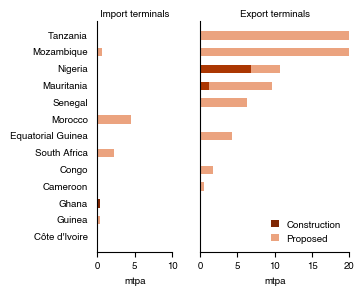

In [210]:
font_size = 7
set_width = 0.5
xmax1 = 10
xmax2 = 20

use_this_df = final_table.replace('', 0)
sorted_indices = final_table.replace('',numpy.nan).sum(axis=1).sort_values().index
use_this_df = use_this_df.reindex(sorted_indices)
ytop = final_table.index.size

fig = mp.figure(figsize=(3.25,3))

gs = fig.add_gridspec(1,2,width_ratios=(1,2),
                      wspace=0.25, hspace=0.)
ax1 = fig.add_subplot(gs[0,0])

ax1.barh(range(use_this_df.index.size), use_this_df['Construction Import'],
       color=tracker_construction, label='Construction', height=set_width)
ax1.barh(range(use_this_df.index.size), use_this_df['Proposed Import'],
       color=tracker_proposed, label='Proposed',
      left=use_this_df['Construction Import'], height=set_width, alpha=0.5)

# ax_l,ax_h = ax.get_legend_handles_labels()
# ax1.legend(ax_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=4)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
#ax1.spines['left'].set_visible(False)
ax1.tick_params(labelsize=font_size,
              left=False)
ax1.set_xlabel('mtpa', size=font_size)

ax1.yaxis.set_ticks(range(use_this_df.index.size))
ax1.yaxis.set_ticklabels(use_this_df.index, size=font_size, va='center')
ax1.set_xlim(0, xmax1)

ax1.text(s='Import terminals',
         x=0.5,y=1.01,
         transform=ax1.transAxes,
         ha='center',va='bottom',
         fontsize=font_size)

##################################################

ax2 = fig.add_subplot(gs[0,1])

ax2.barh(range(use_this_df.index.size), use_this_df['Construction Export'],
       color=tracker_construction, label='Construction', height=set_width)
ax2.barh(range(use_this_df.index.size), use_this_df['Proposed Export'],
       color=tracker_proposed, label='Proposed',
      left=use_this_df['Construction Import'], height=set_width, alpha=0.5)

ax_l,ax_h = ax2.get_legend_handles_labels()
ax2.legend(ax_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=4)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax2.spines['left'].set_visible(False)
ax2.tick_params(labelsize=font_size,
              left=False)
ax2.set_xlabel('mtpa', size=font_size)

ax2.yaxis.set_ticks([])
ax2.yaxis.set_ticklabels([])
ax2.set_xlim(0, xmax2)

ax2.text(s='Export terminals',
         x=0.5,y=1.01,
         transform=ax2.transAxes,
         ha='center',va='bottom',
         fontsize=font_size)


In [211]:
sel_cmap = matplotlib.cm.get_cmap('Oranges')
export_con = sel_cmap(1.0)
export_prop = sel_cmap(0.75)

sel_cmap = matplotlib.cm.get_cmap('Purples')
import_con = sel_cmap(0.999)
import_prop = sel_cmap(0.666)

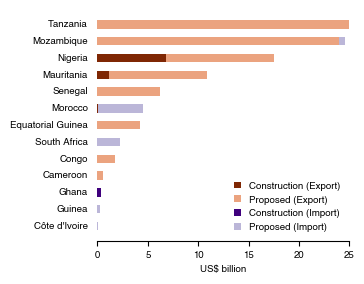

In [213]:
font_size = 7
set_width = 0.5
xmax = 25

use_this_df = final_table.replace('', 0)
sorted_indices = final_table.replace('',numpy.nan).sum(axis=1).sort_values().index
use_this_df = use_this_df.reindex(sorted_indices)
ytop = final_table.index.size

fig = mp.figure(figsize=(3.25,3))

ax = fig.add_subplot(111)

ax.barh(range(use_this_df.index.size), use_this_df['Construction Export'],
       color=export_con, label='Construction (Export)', height=set_width)

ax.barh(range(use_this_df.index.size), use_this_df['Proposed Export'],
       color=export_prop, label='Proposed (Export)',
      left=use_this_df['Construction Export'], height=set_width, alpha=0.5)

ax.barh(range(use_this_df.index.size), use_this_df['Construction Import'],
       color=import_con,
        label='Construction (Import)', height=set_width,
        left=use_this_df[['Construction Export','Proposed Export']].sum(axis=1, min_count=0))

ax.barh(range(use_this_df.index.size), use_this_df['Proposed Import'],
       color=import_prop, alpha=0.5,
        label='Proposed (Import)',
      left=use_this_df[['Construction Export','Proposed Export','Construction Import']].sum(axis=1, min_count=0), 
         height=set_width)

ax_l,ax_h = ax.get_legend_handles_labels()
ax.legend(ax_h, fontsize=font_size, frameon=False, handlelength=0.75, loc=4)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(labelsize=font_size,
              left=False)
ax.set_xlabel('US$ billion', size=font_size)

ax.yaxis.set_ticks(range(use_this_df.index.size))
ax.yaxis.set_ticklabels(use_this_df.index, size=font_size, va='center')
ax.set_xlim(0, xmax)

mp.savefig('saved-figures/exports-and-imports-fig4.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/exports-and-imports-fig4.pdf',
          bbox_inches='tight', 
          transparent=True)

mp.savefig('saved-figures/exports-and-imports-fig4.svg',
          bbox_inches='tight', 
          transparent=True)

# table 14

In [214]:
status = ['Proposed','Construction','Proposed+Construction']
cost_by_country_import_df_subset = cost_by_country_import_df.loc[(cost_by_country_import_df.index.isin(region_df_touse.Country))]
cost_by_country_import_df_subset = cost_by_country_import_df_subset.sort_values('Proposed+Construction', ascending=False)[status]
# sum everything after top 5
upto = 5
rest_of_africa = pandas.DataFrame(cost_by_country_import_df_subset[5:].sum()).transpose()
rest_of_africa.rename(index={0:'Rest of Africa'}, inplace=True)
final_table = pandas.concat([cost_by_country_import_df_subset[:upto],rest_of_africa])
final_table.loc['Total'] = final_table.sum().values
final_table.index.name = 'Country'
final_table/1e9

,Proposed,Construction,Proposed+Construction
Country,,,
Morocco,4.50000,0.00000,4.50000
South Africa,2.26940,0.00000,2.26940
Mozambique,0.55000,0.00000,0.55000
Ghana,0.00000,0.35000,0.35000
Guinea,0.30000,0.00000,0.30000
Rest of Africa,0.05119,0.00000,0.05119
Total,7.67058,0.35000,8.02058


In [215]:
status = ['Proposed','Construction','Proposed+Construction']
cost_by_country_export_df_subset = cost_by_country_export_df.loc[(cost_by_country_export_df.index.isin(region_df_touse.Country))]
cost_by_country_export_df_subset = cost_by_country_export_df_subset.sort_values('Proposed+Construction', ascending=False)[status]
# sum everything after top 5
upto = 5
rest_of_africa = pandas.DataFrame(cost_by_country_export_df_subset[5:].sum()).transpose()
rest_of_africa.rename(index={0:'Rest of Africa'}, inplace=True)
final_table = pandas.concat([cost_by_country_export_df_subset[:upto],rest_of_africa])
final_table.loc['Total'] = final_table.sum().values
final_table.index.name = 'Country'
final_table/1e9

,Proposed,Construction,Proposed+Construction
Country,,,
Tanzania,30.00000,0.00000,30.00000
Mozambique,24.00000,0.00000,24.00000
Nigeria,10.69236,6.84211,17.53447
Mauritania,9.68595,1.15920,10.84515
Senegal,6.23595,0.00000,6.23595
Rest of Africa,6.44624,0.03813,6.48437
Total,87.06050,8.03944,95.09994
